# ***Machine Learning model interpretation***

# 📚 ***Import libraries***

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import load
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

# 💾 ***Load model***

In [4]:
# Load the saved model (preprocessing + XGBoost)
covid_model = load("/workspaces/COVID_DAILY_COUNTS/models/covid_regression-xgboost-v1.joblib")

# ***Model Interpretation***

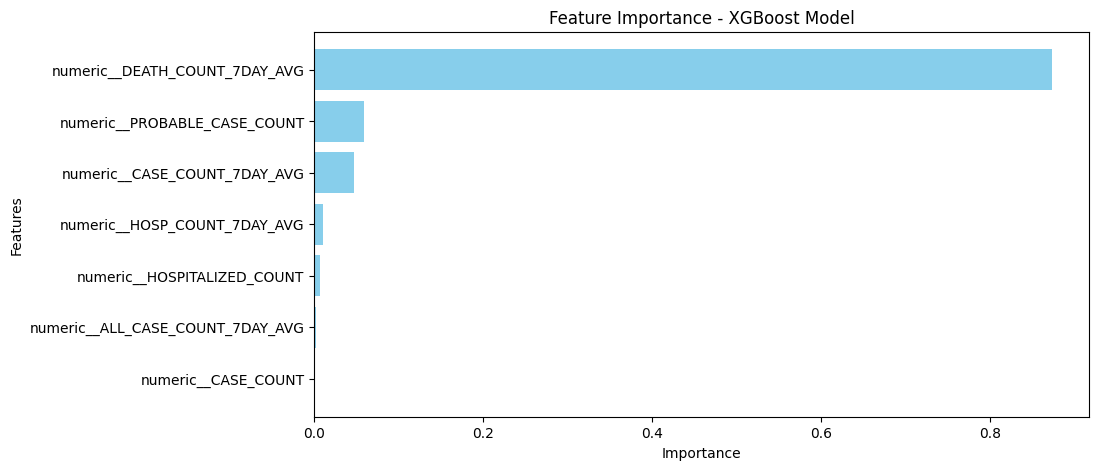

In [5]:
import pandas as pd

features = covid_model["preprocessor"].get_feature_names_out()

importances = covid_model["model"].feature_importances_

df_features = pd.DataFrame({"Features": features, "Importances": importances})
df_features = df_features.sort_values(by="Importances", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(df_features["Features"], df_features["Importances"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost Model")
plt.gca().invert_yaxis()
plt.show()

In [6]:
df_features

,Features,Importances
6,numeric__DEATH_COUNT_7DAY_AVG,0.873947
1,numeric__PROBABLE_CASE_COUNT,0.059294
3,numeric__CASE_COUNT_7DAY_AVG,0.046675
5,numeric__HOSP_COUNT_7DAY_AVG,0.010063
2,numeric__HOSPITALIZED_COUNT,0.006500
4,numeric__ALL_CASE_COUNT_7DAY_AVG,0.002570
0,numeric__CASE_COUNT,0.000950


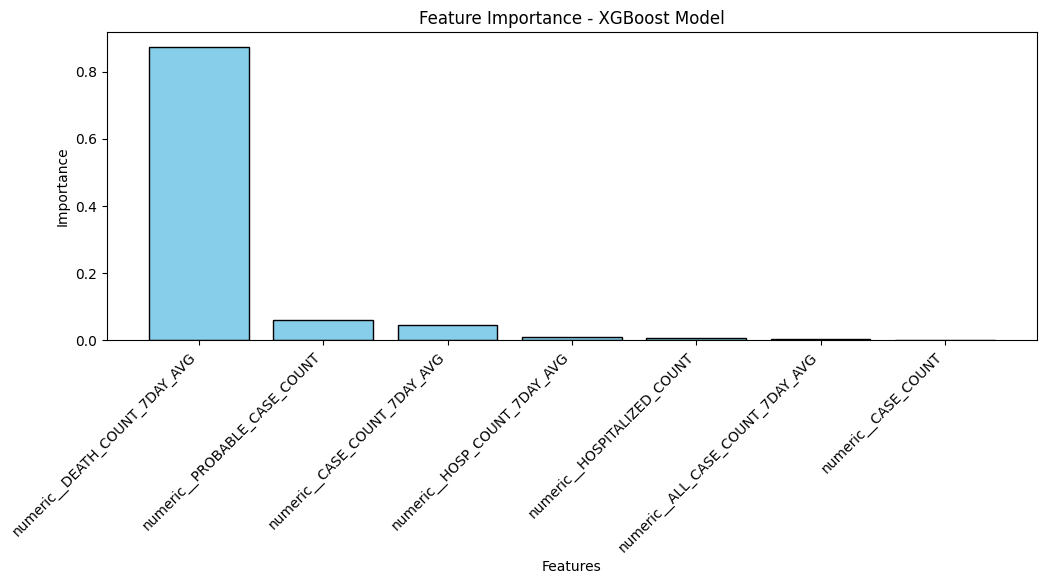

In [7]:
plt.figure(figsize=(12, 4))
plt.bar(
    df_features["Features"],
    df_features["Importances"],
    capsize=5,
    edgecolor="black",
    color="skyblue", 
)

plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance - XGBoost Model")
plt.xticks(rotation=45, ha="right")

plt.show()

## ***Feature permutation***
### 💾 ***Load data***

In [12]:
DATA_DIR = Path.cwd().resolve().parents[1] / "data"
covid_df = pd.read_parquet(DATA_DIR / "02_intermediate/covid_type_fixed.parquet", engine="pyarrow")

covid_df.loc[:, "DEATH_COUNT"] = covid_df["DEATH_COUNT"].astype(int)
covid_df = covid_df.drop_duplicates()

In [13]:
columnas_df = [
    "CASE_COUNT",
    "PROBABLE_CASE_COUNT",
    "HOSPITALIZED_COUNT",
    "DEATH_COUNT",
    "CASE_COUNT_7DAY_AVG",
    "ALL_CASE_COUNT_7DAY_AVG",
    "HOSP_COUNT_7DAY_AVG",
    "DEATH_COUNT_7DAY_AVG",
]
covid_df = covid_df[columnas_df].copy()

In [14]:
X_features = covid_df.drop(columns=["DEATH_COUNT"])
Y_target = covid_df["DEATH_COUNT"]

In [15]:
# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, random_state=42
)

/tmp/ipykernel_11093/2126605521.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


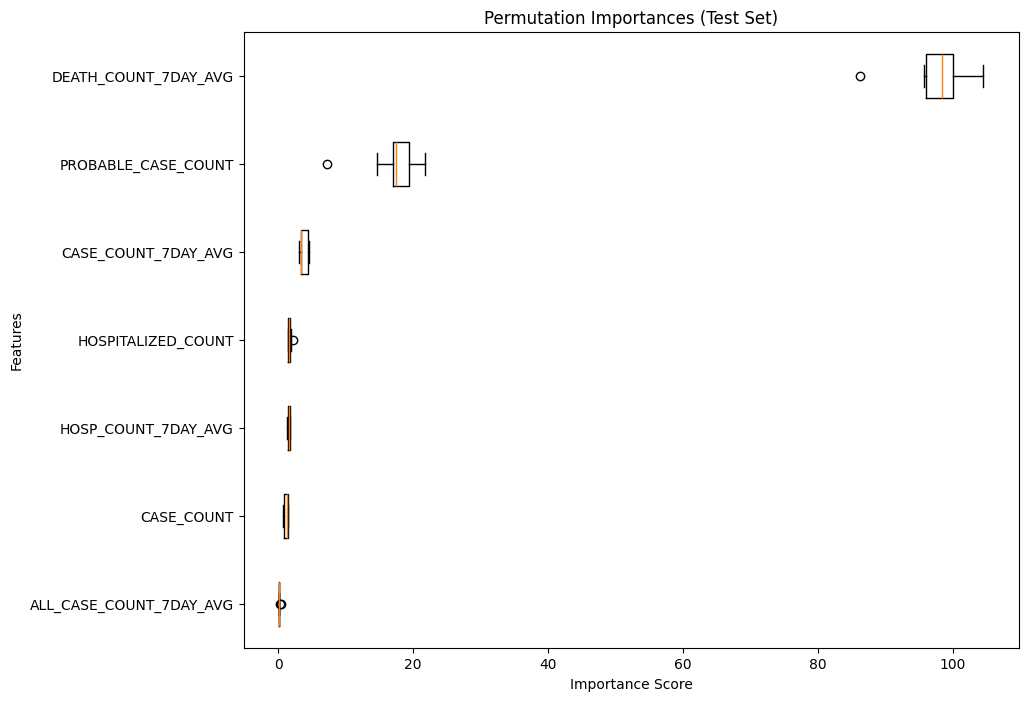

In [16]:
imps = permutation_importance(
    covid_model,
    x_test,
    y_test,
    scoring="neg_root_mean_squared_error",
    n_repeats=10,
    random_state=42,
    n_jobs=8,
)

# Ordenar las importancias de permutación
perm_sorted_idx = imps.importances_mean.argsort()

plt.figure(figsize=(10, 8))
plt.boxplot(
    imps.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(x_test.columns)[perm_sorted_idx],
)
plt.title("Permutation Importances (Test Set)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

Las variables con mayor poder predictivo tendrán un mayor impacto en el rendimiento del modelo cuando se permuten. Basándose en los resultados, las características más importantes es:
- DEATH_COUNT_7DAY_AVG

Con una importancia moderada:

- PROBABLE_CASE_COUNT
- CASE_COUNT_7DAY_AVG

# 📌 ***Interpretación del Modelo y Análisis de Errores***

## **1️⃣ Interpretación del Modelo y Detección de Errores**
El modelo seleccionado, **XGBoost**, mostró un excelente desempeño en la predicción del número de muertes diarias por COVID-19 en la ciudad de Nueva York. Las métricas evaluadas (MAE, MSE, R²) indican que el modelo logra capturar adecuadamente la dinámica de la pandemia en términos generales.

Sin embargo, el análisis de errores revela dificultades para predecir valores extremos, especialmente durante picos pandémicos. Esto sugiere que el modelo puede subestimar la mortalidad en contextos inusuales.

## **2️⃣ ¿Qué variables son más importantes?**
Según el análisis de **importancia de características** (tanto por `feature_importance_` de XGBoost como por **importancia por permutación**), las variables más influyentes en la predicción son:

- `DEATH_COUNT_7DAY_AVG` ⚰️  
- `PROBABLE_CASE_COUNT` 🧪  
- `CASE_COUNT_7DAY_AVG` 📈

La variable `DEATH_COUNT_7DAY_AVG` tiene una importancia **abrumadora** con más del **87% de peso relativo**, lo que indica que el modelo confía casi exclusivamente en esta media móvil para predecir las muertes.

## **3️⃣ ¿Cuánto aporta cada variable a la predicción?**
Con base en las gráficas y tablas:

- **`DEATH_COUNT_7DAY_AVG`** representa aproximadamente el **87%** de la importancia total del modelo.  
- **`PROBABLE_CASE_COUNT`** contribuye con cerca de **6%**.  
- Otras variables (`CASE_COUNT_7DAY_AVG`, `HOSPITALIZED_COUNT`, etc.) tienen aportes menores a **5%**.

Este patrón fue consistente tanto en la importancia directa del modelo como en el análisis de permutación sobre el set de prueba.

## **4️⃣ Consecuencias de Predicciones Incorrectas**
Errores en la predicción de muertes pueden tener implicaciones serias:

- **Subestimación de muertes** 🚨  
  - Puede generar respuestas insuficientes por parte del sistema de salud.  
  - Retrasos en la implementación de medidas de emergencia.

- **Sobreestimación de muertes** 😱  
  - Puede causar alarmismo innecesario.  
  - Afecta la percepción pública y puede tener impactos económicos o sociales.

Minimizar estos errores es clave para decisiones basadas en datos durante crisis sanitarias.

## **5️⃣ ¿Qué tipo de errores comete el modelo?**
El análisis de residuos revela que los errores más significativos ocurren en:

- **Días con picos extremos de muertes.**  
- **Transiciones rápidas** entre períodos de baja y alta mortalidad.  

Estos errores se concentran en los extremos del rango de valores, lo cual puede atribuirse a la escasa representación de dichos eventos en el entrenamiento.

## **6️⃣ ¿Qué causa estos errores?**
Las posibles causas de los errores detectados incluyen:

✅ **Dependencia excesiva de una sola variable:**  
   - La dominancia de `DEATH_COUNT_7DAY_AVG` podría estar ocultando el aporte de otras variables más dinámicas.

✅ **Falta de variables contextuales:**  
   - Factores como campañas de vacunación, movilidad, o medidas de confinamiento no están incorporadas, y podrían mejorar la predicción en escenarios atípicos.

## 🧪 ***Conclusión***
El modelo **XGBoost** es sólido y preciso para la predicción de muertes por COVID-19, pero **su generalización ante valores extremos aún puede mejorarse**.